In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Useful Functions

In [2]:
def ax_standard(ax):

    ax.grid(True, alpha=0.5)
    ax.set_xlabel("Epoch")

def plot_results(history):

    line_color = "#f07167"

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.tight_layout(pad=5)

    ax[0].plot(history["loss"], color = line_color)
    ax_standard(ax[0])
    ax[0].set_ylabel("Total Loss")


    ax[1].plot(history["kl_loss"], color = line_color)
    ax_standard(ax[1])
    ax[1].set_ylabel("KL Loss")


    ax[2].plot(history["reconstruction_loss"], color = line_color)
    ax_standard(ax[2])
    ax[2].set_ylabel("Reconstruction Loss")

In [3]:
def plot_training_vs_validation_loss(history):
    """
    Plots the total loss, reconstruction loss, and KL divergence loss
    for both training and validation.

    Parameters:
    history: Keras history object containing training and validation loss values per epoch.
    """
    plt.figure(figsize=(10, 5))

    # Plot total loss
   # plt.plot(history.history["loss"], label="Train Loss", color="#545f66")
   # plt.plot(history.history["val_loss"], label="Validation Loss", color="#829399", linestyle="dashed")

    # Plot reconstruction loss
    plt.plot(history.history["reconstruction_loss"], label="Train Reconstruction Loss", color="#8BE4CB")
    #plt.plot(history.history["val_reconstruction_loss"], label="Validation Reconstruction Loss", color="#DAFA9E", linestyle="dashed")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Training vs. Validation Reconstruction Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    # Plot KL loss
    plt.plot(history.history["loss"], label="Total Loss", color="#b1cc74")
    #plt.plot(history.history["val_kl_loss"], label="Validation KL Loss", color="#DAFA9E", linestyle="dashed")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Training vs. Validation Kl_loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(history.history["kl_loss"], label="KL Loss", color="#b1cc74")
    #plt.plot(history.history["val_kl_loss"], label="Validation KL Loss", color="#DAFA9E", linestyle="dashed")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.title("Training vs. Validation Kl_loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage (after training the VAE model)
# plot_training_vs_validation_loss(vae.history)  # Uncomment this after training is completed


In [4]:
latent_dim = 15

### Paper Immplementation

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        #self.seed_generator = keras.random.SeedGenerator(3718)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        time_dim = ops.shape(z_mean)[1]
        dim = ops.shape(z_mean)[2]
        epsilon = tf.keras.backend.random_normal(shape=(batch,time_dim, dim)) #batch, time steps, latent dim
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class Sampling_t1(layers.Layer):
      def __init__(self, **kwargs):
        super().__init__(**kwargs)
        #self.seed_generator = keras.random.SeedGenerator(3718)

      def call(self, inputs):
          z_mean, z_log_var = inputs
          batch = ops.shape(z_mean)[0]
          #time_dim = ops.shape(z_mean)[1]
          dim = ops.shape(z_mean)[1]
          epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) #batch,  latent dim
          return z_mean + tf.exp(0.5 * z_log_var) * epsilon
#dynamically for shape
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [6]:

import numpy as np
import tensorflow as tf

# Generate synthetic sine wave sequences
def generate_sine_data(num_samples=1000, sequence_length=200, noise_level=0.1):
    """
    Generate sine wave sequences with slight variations.
    num_samples: Number of sequences.
    sequence_length: Number of time steps per sequence.
    noise_level: Amplitude of added random noise.
    Returns: (num_samples, sequence_length, 1) shape dataset
    """
    X = []
    for _ in range(num_samples):
        freq = np.random.uniform(0.1, 0.5)  # Random frequency
        phase = np.random.uniform(0, np.pi)  # Random phase shift
        sequence = np.sin(np.linspace(0, 2 * np.pi * freq, sequence_length) + phase)
        sequence += np.random.normal(0, noise_level, sequence_length)  # Add noise
        X.append(sequence)

    X = np.array(X).reshape(num_samples, sequence_length, 1)  # Reshape for LSTM input
    return X

# Generate data
X_train = generate_sine_data(num_samples=1000)
X_val = generate_sine_data(num_samples=200)

# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(32)

print("Training Data Shape:", X_train.shape)  # (1000, 20, 1)
print("Validation Data Shape:", X_val.shape)  # (200, 20, 1)


Training Data Shape: (1000, 200, 1)
Validation Data Shape: (200, 200, 1)


Training Data Shape: (1000, 200, 1)
Validation Data Shape (200, 200, 1)


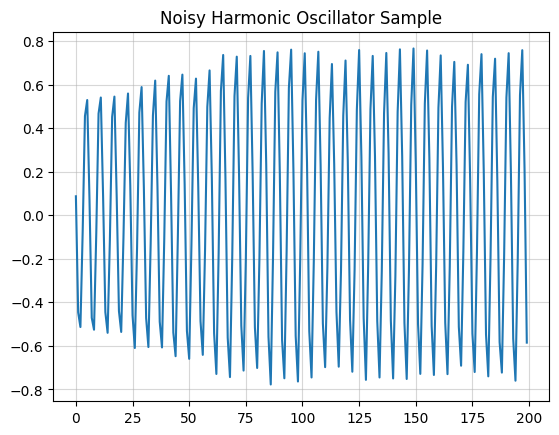

In [7]:
#Genearte noisy harmonic generator


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def generate_harmonic_oscillator_data(num_samples=1000, sequence_length=200,
                                      mass=1.0, k_range=(0.5, 2.0),
                                      noise_level=0.05):
    """
    Generate noisy harmonic oscillator sequences.
    Returns: shape (num_samples, sequence_length, 1)
    """
    X = []
    np.random.seed(100)

    for _ in range(num_samples):
        # Random spring constant and angular frequency
        #k = np.random.uniform(*k_range)
        k = 1

        omega = np.sqrt(k / mass)

        # Initial conditions
        pos = np.zeros(sequence_length)
        vel = np.zeros(sequence_length)
        pos[0] = np.random.uniform(-1, 1)
        vel[0] = np.random.uniform(-1, 1)

        dt = 1.0
        for t in range(1, sequence_length):
            acc = - (k / mass) * pos[t - 1]

            #euler integration
            vel[t] = vel[t - 1] + dt * acc
            pos[t] = pos[t - 1] + dt * vel[t]

            # Add noise to velocity and position
            vel[t] += np.random.normal(0, noise_level)
            pos[t] += np.random.normal(0, noise_level)

        X.append(pos)

    X = np.array(X).reshape(num_samples, sequence_length, 1)
    return X

# Generate data
X_train = generate_harmonic_oscillator_data(num_samples=1000, noise_level=0.01)
X_val = generate_harmonic_oscillator_data(num_samples=200)


print("Training Data Shape:", X_train.shape)
print("Validation Data Shape", X_val.shape)
# Convert to TensorFlow dataset
#train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(32)

# Plot a sample
plt.plot(X_train[0])
plt.title("Noisy Harmonic Oscillator Sample")
plt.grid(True, alpha=0.5)
plt.show()


In [8]:
latent_dim = 15

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Generate data
X_train_np = generate_harmonic_oscillator_data(num_samples=1000, noise_level=0.01)
X_val_np = generate_harmonic_oscillator_data(num_samples=200, noise_level=0.01)

# Convert to tensors for pytorch
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)

# Wrap into datasets
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #shape 100 x 200 x 1
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) #shape 200 x 200 x 1

In [10]:
for batch in train_loader:
    x = batch[0]
    print(x.shape)

torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([64, 200, 1])
torch.Size([40, 200, 1])


In [11]:
# Latent dynamics function in pytorch

import torch
import torch.nn as nn

class LatentDynamics(nn.Module):
    def __init__(self, latent_dim):
        super(LatentDynamics, self).__init__()
        self.latent_dim = latent_dim

        # Trainable diagonal of transition matrix A
        self.A_diag = nn.Parameter(torch.ones(latent_dim))

        # Trainable log of diagonal of covariance matrix
        self.log_cov_diag = nn.Parameter(torch.zeros(latent_dim))

    def forward(self, inputs=None):  # `inputs` kept for compatibility
        cov_diag = torch.exp(self.log_cov_diag)
        return self.A_diag, cov_diag


In [12]:
latent_dynamics = LatentDynamics(latent_dim)
A_diag, cov_diag = latent_dynamics()

A_diag.shape, cov_diag.shape

(torch.Size([15]), torch.Size([15]))

In [13]:
import random

In [14]:
def time_interval():

  prob = random.random()
  if prob < 0.8: #time interval [1,10] with prob 0.8
    t2 = random.randint(10,199) # max time interval is 10, so if t2 < 10 t1 will be negative if dt = 10
    t1 = random.randint(t2-10,t2-1)
  else: #time interval [1,120] with prob 0.2
    t2 = random.randint(120,199)
    t1 = random.randint(t2-120,t2-1)
    print(t1)
  return t1, t2

def log_normal_pdf(x, mean, logvar):
  return - 0.5 *(
      tf.reduce_sum(tf.math.log(2. * np.pi) + logvar + tf.square(x - mean)/ tf.exp(logvar), axis = -1)
  )

def A_poly(A, power):
    r""""
    Returns a decresing polynomial in powers of A.
    Ex: For power = 3, returns A^3 + A^2 + A + 1
    """
    if power == 0: return 1
    return pow(A,power) + A_poly(A, power-1)



In [15]:
"""
encoder_inputs = keras.Input(shape = (200,1))
bt = layers.LSTM(64, return_sequences = True)(encoder_inputs)
bt = layers.LSTM(32, return_sequences = True, name = 'bt')(bt) # (time, 32)
#TODO: Implement a DENSE layer to get bt instead of assuming x is bt
#belief state
# This is Pb at all times, use the time index to get Pbt1 and Pbt2
z_mean = layers.Dense(latent_dim, name = 'z_mean_t')(bt) # (time, latentDim) (20,15)
z_log_var = layers.Dense(latent_dim, name = 'z_log_var_t')(bt)

#zt2, this will directly be used in the decoder, no t2 entire thing can be passed into decoder
zt = Sampling()([z_mean, z_log_var]) #(time , latent dim samples)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, zt, bt ], name="encoder")
encoder.summary()
"""

'\nencoder_inputs = keras.Input(shape = (200,1))\nbt = layers.LSTM(64, return_sequences = True)(encoder_inputs)\nbt = layers.LSTM(32, return_sequences = True, name = \'bt\')(bt) # (time, 32)\n#TODO: Implement a DENSE layer to get bt instead of assuming x is bt\n#belief state\n# This is Pb at all times, use the time index to get Pbt1 and Pbt2\nz_mean = layers.Dense(latent_dim, name = \'z_mean_t\')(bt) # (time, latentDim) (20,15)\nz_log_var = layers.Dense(latent_dim, name = \'z_log_var_t\')(bt)\n\n#zt2, this will directly be used in the decoder, no t2 entire thing can be passed into decoder\nzt = Sampling()([z_mean, z_log_var]) #(time , latent dim samples)\n\nencoder = keras.Model(encoder_inputs, [z_mean, z_log_var, zt, bt ], name="encoder")\nencoder.summary()\n'

In [16]:
X_train.shape



(1000, 200, 1)

In [17]:

#Pytorch implementation

import torch
import torch.nn as nn

class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mean, z_log_var):
        eps = torch.randn_like(z_mean)
        return z_mean + eps * torch.exp(0.5 * z_log_var)

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)  # "bt" output

        # Linear layers for z_mean and z_log_var (per time step)
        self.z_mean_t = nn.Linear(32, latent_dim)
        self.z_log_var_t = nn.Linear(32, latent_dim)

        self.sampling = Sampling()

    def forward(self, x):
        # x shape: (batch, 200, 1)
        bt, _ = self.lstm1(x)  # 64x200x1 =}  64x200x64
        bt, _ = self.lstm2(bt)  # bt: (batch, time, 32) 64x200x32

        z_mean = self.z_mean_t(bt)      # (batch, time, latent_dim) 64x200x32 - 64x200x15
        z_log_var = self.z_log_var_t(bt) # 64x200x15
        zt = self.sampling(z_mean, z_log_var)  # (batch, time, latent_dim) zt: (64, 200, 15)

        return z_mean, z_log_var, zt, bt



In [18]:
"""
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)
decoder_outputs = layers.Dense(1, activation="sigmoid")(x)  # Predict just x_{t2}

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
"""

'\nlatent_inputs = keras.Input(shape=(latent_dim,))\nx = layers.Dense(32, activation="relu")(latent_inputs)\nx = layers.Dense(64, activation="relu")(x)\ndecoder_outputs = layers.Dense(1, activation="sigmoid")(x)  # Predict just x_{t2}\n\ndecoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")\ndecoder.summary()\n'

In [ ]:
#decoder: Pytorch implementation


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)#,
            #nn.Sigmoid() #TODO: is sigmoid the most appropriate 
        )

    def forward(self, z):
        return self.decoder(z)  # Output shape: (batch, 1)


In [20]:
"""
smoothing_input = keras.Input(shape = (latent_dim+32+32 +1,)) #latent_dim + bt1+ bt2 + time interval
qs_mean = layers.Dense(latent_dim, name = 'qs_mean_t1')(smoothing_input) # (latentDim) (15)
qs_log_var = layers.Dense(latent_dim, name = 'qs_log_var_t1')(smoothing_input)

zt1 = Sampling()([qs_mean, qs_log_var]) #( latent dim samples)
smoothing = keras.Model(smoothing_input,[zt1,qs_mean,qs_log_var], name = "smoothing")
smoothing.summary()
"""

'\nsmoothing_input = keras.Input(shape = (latent_dim+32+32 +1,)) #latent_dim + bt1+ bt2 + time interval\nqs_mean = layers.Dense(latent_dim, name = \'qs_mean_t1\')(smoothing_input) # (latentDim) (15)\nqs_log_var = layers.Dense(latent_dim, name = \'qs_log_var_t1\')(smoothing_input)\n\nzt1 = Sampling()([qs_mean, qs_log_var]) #( latent dim samples)\nsmoothing = keras.Model(smoothing_input,[zt1,qs_mean,qs_log_var], name = "smoothing")\nsmoothing.summary()\n'

In [ ]:
class Smoothing(nn.Module):
    def __init__(self, latent_dim):
        super(Smoothing, self).__init__()
        input_dim = latent_dim + 32 + 32 + 1  # z_t2 + b_t1 + b_t2 + delta_t

        self.qs_mean_t1 = nn.Linear(input_dim, latent_dim)  # 80 → 15 64x15
        self.qs_log_var_t1 = nn.Linear(input_dim, latent_dim)  # 80 → 15 64x15
        self.sampling = Sampling()

    def forward(self, smoothing_input):
        # smoothing_input shape: (batch, latent_dim + 32 + 32 + 1)
        qs_mean = self.qs_mean_t1(smoothing_input)      # (batch, latent_dim)  # (64, 15)
        qs_log_var = self.qs_log_var_t1(smoothing_input)  # (64, 15)
        zt1 = self.sampling(qs_mean, qs_log_var)        # (batch, latent_dim)  # (64, 15)

        return zt1, qs_mean, qs_log_var #all have shape = (latent_dim)


In [22]:
"""
transition_input = keras.Input(shape = (latent_dim + 1,)) #latent dim + time interval
pt_mean = layers.Dense(latent_dim, name = 'pt_mean_t1')(transition_input) # (latentDim) (15)
pt_log_var = layers.Dense(latent_dim, name = 'pt_log_var_t1')(transition_input)

transition = keras.Model(transition_input,[pt_mean,pt_log_var], name = "transition_dense")
transition.summary()
"""

'\ntransition_input = keras.Input(shape = (latent_dim + 1,)) #latent dim + time interval\npt_mean = layers.Dense(latent_dim, name = \'pt_mean_t1\')(transition_input) # (latentDim) (15)\npt_log_var = layers.Dense(latent_dim, name = \'pt_log_var_t1\')(transition_input)\n\ntransition = keras.Model(transition_input,[pt_mean,pt_log_var], name = "transition_dense")\ntransition.summary()\n'

In [23]:
import torch
import torch.nn as nn

class Transition(nn.Module):
    def __init__(self, latent_dim):
        super(Transition, self).__init__()
        input_dim = latent_dim + 1  # z_t1 + delta_t

        self.pt_mean_t1 = nn.Linear(input_dim, latent_dim)
        self.pt_log_var_t1 = nn.Linear(input_dim, latent_dim)

    def forward(self, transition_input):
        # transition_input shape: (batch, latent_dim + 1)
        pt_mean = self.pt_mean_t1(transition_input)      # (batch, latent_dim)
        pt_log_var = self.pt_log_var_t1(transition_input)
        return pt_mean, pt_log_var


In [24]:
"""
def log_normal_pdf(x, mean, logvar):
  return - 0.5 *(
      tf.reduce_sum(tf.math.log(2. * np.pi) + logvar + tf.square(x - mean)/ tf.exp(logvar), axis = -1)
  )

def A_poly(A, power):

    #Returns a decresing polynomial in powers of A.
    #Ex: For power = 3, returns A^3 + A^2 + A + 1

    if power == 0: return 1
    return pow(A,power) + A_poly(A, power-1)
"""

'\ndef log_normal_pdf(x, mean, logvar):\n  return - 0.5 *(\n      tf.reduce_sum(tf.math.log(2. * np.pi) + logvar + tf.square(x - mean)/ tf.exp(logvar), axis = -1)\n  )\n\ndef A_poly(A, power):\n\n    #Returns a decresing polynomial in powers of A.\n    #Ex: For power = 3, returns A^3 + A^2 + A + 1\n\n    if power == 0: return 1\n    return pow(A,power) + A_poly(A, power-1)\n'

In [25]:
def log_normal_pdf(x, mean, logvar, eps=1e-6):
    log_two_pi = torch.log(torch.tensor(2. * math.pi, device=x.device, dtype=x.dtype))
    return -0.5 * torch.sum(
        log_two_pi + logvar + ((x - mean) ** 2) / (torch.exp(logvar) + eps),
        dim=-1
    )

def A_poly(A, power):
    """
    Returns A^power + A^(power-1) + ... + A + I
    """
    if power == 0:
        return torch.eye(A.size(0), device=A.device, dtype=A.dtype)  # Identity matrix
    result = torch.zeros_like(A)
    for i in range(power + 1):
        result += torch.matrix_power(A, i)
    return result


In [26]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, encoder, decoder, smoothing, transition, latent_dim, transition_matrix_A, prior_covariance, Markov_Prior=0):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.smoothing = smoothing
        self.transition = transition
        self.Markov_Prior = Markov_Prior

        self.A = transition_matrix_A  # shape: (latent_dim, latent_dim)
        self.cov = prior_covariance   # shape: (latent_dim,) or (latent_dim, latent_dim)

        # You can track losses using simple Python variables in your training loop
        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    def reset_loss_trackers(self):
        self.total_loss = 0.0
        self.reconstruction_loss = 0.0
        self.kl_loss = 0.0

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data, optimizer, device):

      data = data.to(device)

      if self.Markov_Prior == 1:
          # === Markov Prior ===
          z_mean, z_log_var, z, bt = self.encoder(data)

          t1, t2 = time_interval()
          bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each
          zt2 = z[:, t2, :] #(64,15)
          dt = (t2 - t1) * torch.ones((bt1.shape[0], 1), device=device) #(64,1)

          smoothing_inputs = torch.cat((bt1, bt2, zt2, dt), dim=-1) # (64, 80) → (64, 15)
          zt1, qs_mean, qs_log_var = self.smoothing(smoothing_inputs) #(64,15) each


          #A_pow = self.A.to(device) ** (t2 - t1)
          A_pow = torch.matrix_power(self.A, t2 - t1)
          pt_mean = zt1 @ A_pow.T   # (64, 15) @ (15, 15).T → (64, 15) Matrix multiplication
          pt_log_var = torch.log(self.cov) * A_poly(self.A, t2 - t1 - 1)

      else:
          # === Non-Markov ===
          z_mean, z_log_var, z, bt = self.encoder(data)

          t1, t2 = time_interval()
          bt1, bt2 = bt[:, t1, :], bt[:, t2, :]  #(64,32) each
          zt2 = z[:, t2, :] #(64,15)
        #   dt = (t2 - t1) * torch.ones((bt1.shape[0], 1), device=device) #(64,1)
          dt = torch.full((x.size(0), 1), t2 - t1, dtype=bt1.dtype, device=x.device)

          smoothing_inputs = torch.cat((bt1, bt2, zt2, dt), dim=-1)   #(64,80)
          zt1, qs_mean, qs_log_var = self.smoothing(smoothing_inputs)  #(64,15) each

          trans_input = torch.cat((zt1, dt), dim=-1)
          pt_mean, pt_log_var = self.transition(trans_input)

      # === Decoder ===
      reconstruction = self.decoder(zt2)
      target = data[:, t2, :]

      # === Losses ===
      mse = torch.nn.MSELoss()
      reconstruction_loss = mse(reconstruction, target)

      log_pzt1_bt1 = log_normal_pdf(zt1, z_mean[:, t1, :], z_log_var[:, t1, :])#.sum(dim=1)
      log_pzt2_zt1 = log_normal_pdf(zt2, pt_mean, pt_log_var)#.sum(dim=1)
      log_pzt2_bt2 = log_normal_pdf(zt2, z_mean[:, t2, :], z_log_var[:, t2, :])#.sum(dim=1)
      log_qzt1_given_all = log_normal_pdf(zt1, qs_mean, qs_log_var)#.sum(dim=1)

      kl_loss = (log_pzt1_bt1 - log_qzt1_given_all).mean()
      total_kl = (log_pzt1_bt1 + log_pzt2_zt1 - log_pzt2_bt2 - log_qzt1_given_all).mean()

      total_loss = reconstruction_loss - total_kl

      # === Backward and optimize ===
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      # === Return metrics ===
      return {
          'loss': total_loss.item(),
          'reconstruction_loss': reconstruction_loss.item(),
          'kl_loss': -kl_loss.item()
      }

In [27]:
# Instances of the network classes

encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
smoothing = Smoothing(latent_dim)
transition = Transition(latent_dim)


In [28]:
A_diag.shape

torch.Size([15])

In [29]:
A_diag = torch.eye(15, dtype=torch.float32, device=device)  # or torch.rand(3, 3)
cov = torch.ones(15, dtype=torch.float32, device=device)    # or torch.eye(3)

In [30]:
# Testing the Network
import math


vae = VAE(encoder, decoder, smoothing, transition, latent_dim=3, transition_matrix_A=A_diag, prior_covariance=cov, Markov_Prior=0)       # construct the model
vae.to(device)        # move to GPU/CPU
vae.train()           # <- do not remove or redefine this!
vae.reset_loss_trackers()

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for batch in train_loader:
    x = batch[0].to(device)
    print(x.shape)
    metrics = vae.train_step(x, optimizer, device)
    print(metrics)

torch.Size([64, 200, 1])
159
{'loss': 6952.455078125, 'reconstruction_loss': 0.685431182384491, 'kl_loss': 41.29490661621094}
torch.Size([64, 200, 1])
{'loss': 12.525103569030762, 'reconstruction_loss': 1.0319262742996216, 'kl_loss': 2.317070960998535}
torch.Size([64, 200, 1])
{'loss': 15.113569259643555, 'reconstruction_loss': 0.5850523114204407, 'kl_loss': 2.1418473720550537}
torch.Size([64, 200, 1])
{'loss': 46.67323303222656, 'reconstruction_loss': 0.608619749546051, 'kl_loss': 4.877772331237793}
torch.Size([64, 200, 1])
147
{'loss': 54.895774841308594, 'reconstruction_loss': 0.45463407039642334, 'kl_loss': 5.679769515991211}
torch.Size([64, 200, 1])
{'loss': 6.265719413757324, 'reconstruction_loss': 0.9599292278289795, 'kl_loss': 1.0299123525619507}
torch.Size([64, 200, 1])
{'loss': 33.47584533691406, 'reconstruction_loss': 0.5694950819015503, 'kl_loss': 4.972285747528076}
torch.Size([64, 200, 1])
134
{'loss': 3838.187744140625, 'reconstruction_loss': 1.112637996673584, 'kl_loss':

# Test

we pick time t1 = 60 and sample $z_{t_{1}}$ from $P_{b}(z_{t_{1}}|b_{t1})$.

In [67]:
num_samples = 10
X_test = generate_sine_data(num_samples)

In [36]:
t1 = 60
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
z_mean, z_log_var, z, bt = encoder(X_test_tensor)
zt1 = z[:,t1,:] #(num_samples,latent dim)
zt1.shape



torch.Size([10, 15])

Then we choose the a time interval $δ_{t} = [20,100]$ to skip, sample from the forward model $P(z_{2} | z_1, δ_{t})$ to obtain $z_{t_{2}}$ at $t_2 = t_1 +  δ_{t}$

In [78]:
def sample_gaussian(z_mean, z_log_var):
    epsilon = torch.randn_like(z_mean)
    return z_mean + torch.exp(0.5 * z_log_var) * epsilon


In [79]:

dt = np.random.randint(20, 101)
dt = torch.full((num_samples, 1), dt, dtype=zt1.dtype, device=zt1.device)

trans_input = torch.cat((zt1, dt), dim=-1)
pt_mean, pt_log_var = transition(trans_input)

zt2 = sample_gaussian(pt_mean, pt_log_var)
#my transition model doesnt sample so have to do it seperately


In [ ]:
num_rollout_steps = 20
delta = torch.ones((zt2.size(0),1), dtype=zt2.dtype, device=zt2.device) #(10,1)

z_current = zt2
z_rollput = []

for _ in range(num_rollout_steps):
trans_input = torch.cat((z_current, delta), dim=-1)
pt_mean, pt_log_var = transition(trans_input)
z_next = sample_gaussian

torch.Size([10, 15])

In [38]:
def mse_loss(x,z):
  return (x-z)**2


In [39]:
from tqdm import tqdm

def dense_layer(X_test,t1,zt1):
  loss = []
  for dt in tqdm(range(20,139)):
    #for i in range(num_samples):
    dt1 = tf.fill([tf.shape(zt1)[0], 1], tf.cast(dt, dtype=zt1.dtype))

    zt2_mean, zt2_log_var = transition(tf.concat([zt1, dt1], axis=-1))
    zt2 = sample_gaussian(zt2_mean, zt2_log_var)
      #my transition model doesnt sample so have to do it seperately

    xt2 = decoder(zt2)

    loss.append(np.mean(mse_loss(xt2, X_test[:,t1+dt])))



  return loss


def markov_prior(X_test,t1,zt1):
  trained_A = vae.A  # shape: (latent_dim,)
  trained_cov = vae.cov  # shape: (latent_dim,)
  loss = []
  for dt in tqdm(range(20,139)):
      zt2_mean = zt1 * tf.pow(trained_A, dt)  # element-wise multiplication
      zt2_log_var = tf.math.log(trained_cov)*A_poly(trained_A,dt-1)

      zt2 = sample_gaussian(zt2_mean, zt2_log_var)
      xt2 = decoder(zt2)
      loss.append(np.mean(mse_loss(xt2, X_test[:,t1+dt])))


  return loss






In [ ]:
markov_loss = markov_prior(X_test,t1,zt1)

In [ ]:
from scipy.interpolate import UnivariateSpline
x = np.arange(20, len(markov_loss) + 20)
spline = UnivariateSpline(x, markov_loss, s=10)
markov_loss_smoothed = spline(x)

plt.plot(x, markov_loss, alpha = 0.25, color="#161a1d", label="Raw Results")
plt.plot(x, markov_loss_smoothed, color = "#e5383b", label="Spline Interpolation")
plt.grid(True, alpha=0.25)
plt.xlabel("Time Skip (dt)")
plt.ylabel("MSE Loss")
plt.title("Transition: Markov Prior")
plt.legend()
plt.show()

In [ ]:
dense_loss = dense_layer(X_test,t1,zt1)


In [ ]:
plt.plot(dense_loss)

In [ ]:
# Generate Sample Preds

def markov_gen(X_test,t1,zt1):
  trained_A = vae.A  # shape: (latent_dim,)
  trained_cov = vae.cov  # shape: (latent_dim,)
  loss = []
  for dt in tqdm(range(20,139)):
      zt2_mean = zt1 * tf.pow(trained_A, dt)  # element-wise multiplication
      zt2_log_var = tf.math.log(trained_cov)*A_poly(trained_A,dt-1)

      zt2 = sample_gaussian(zt2_mean, zt2_log_var)
      xt2 = decoder(zt2)

  return xt2

preds_markov = markov_gen(X_test, t1, zt1)
preds_markov.shape


In [ ]:
plt.plot(X_test[0])